In [6]:
#!pip install catboost

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import *
from sklearn.metrics import log_loss, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn import set_config
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split 
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [8]:
def reading_data(path):
    train = pd.read_csv(path + 'Train%20(6).csv')
    test = pd.read_csv(path +'Test%20(4).csv')
    sub = pd.read_csv(path +'submission%20(5).csv')
    id = test['id']

    return train,test,sub,id

train,test,sub,id = reading_data(path='https://raw.githubusercontent.com/Asmaa6777/Vegetation-Mapping-/main/')

X_train = train.copy()
X_test = test.copy()
X_test = test.drop('id', axis=1)
X_train = X_train.drop('Target', axis=1)
X_train = X_train.drop('id', axis=1)
y_train = train['Target']

In [9]:
isolation_forest = IsolationForest(contamination=0.1) 
is_inlier = isolation_forest.fit_predict(X_train) 


X_train_cleaned = X_train[is_inlier == 1]
y_train_cleaned = y_train[is_inlier == 1]

le = LabelEncoder()
y_train = le.fit_transform(y_train) #not needed
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_cleaned , y_train_cleaned, test_size=0.2, random_state=42 )

In [10]:
cat = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45,  
                           random_seed=42)


cat_modle = cat.fit(X_train_cleaned, y_train_cleaned, eval_set=(X_valid, y_valid), verbose=100)

0:	learn: 3.7379427	test: 3.7418986	best: 3.7418986 (0)	total: 276ms	remaining: 2m 17s
100:	learn: 2.2187134	test: 2.2445540	best: 2.2445540 (100)	total: 19.7s	remaining: 1m 17s
200:	learn: 1.7142579	test: 1.7373166	best: 1.7373166 (200)	total: 39.4s	remaining: 58.6s
300:	learn: 1.3204348	test: 1.3449418	best: 1.3449418 (300)	total: 1m 3s	remaining: 42s
400:	learn: 1.0117881	test: 1.0335485	best: 1.0335485 (400)	total: 1m 23s	remaining: 20.6s
499:	learn: 0.7781919	test: 0.7953611	best: 0.7953611 (499)	total: 1m 44s	remaining: 0us

bestTest = 0.7953611054
bestIteration = 499



In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X_train_cleaned = X_train_cleaned.reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

for train_index, valid_index in skf.split(X_train_cleaned, y_train_cleaned):
   
    X_train_fold, X_valid_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[valid_index]
cat_model = cat.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold), verbose=100)

train_score = cat_model.score(X_train_fold, y_train_fold)
valid_score = cat_model.score(X_valid_fold, y_valid_fold)

train_results = []
valid_results = []

train_results.append(train_score)
valid_results.append(valid_score)

# Print the average scores
print(f'Average training score: {np.mean(train_results):.4f}')
print(f'Average validation score: {np.mean(valid_results):.4f}')

0:	learn: 3.7462007	test: 3.7599118	best: 3.7599118 (0)	total: 191ms	remaining: 1m 35s
100:	learn: 2.1492350	test: 3.3510936	best: 3.3481757 (92)	total: 19.1s	remaining: 1m 15s
200:	learn: 1.6211254	test: 3.3732750	best: 3.3481757 (92)	total: 39.1s	remaining: 58.1s
300:	learn: 1.2019724	test: 3.4288040	best: 3.3481757 (92)	total: 59.1s	remaining: 39.1s
400:	learn: 0.8858457	test: 3.4816295	best: 3.3481757 (92)	total: 1m 18s	remaining: 19.3s
499:	learn: 0.6558039	test: 3.5350152	best: 3.3481757 (92)	total: 1m 36s	remaining: 0us

bestTest = 3.348175683
bestIteration = 92

Shrink model to first 93 iterations.
Average training score: 0.5818
Average validation score: 0.0995


In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_results = []
valid_results = []

X_train_cleaned = X_train_cleaned.reset_index(drop=True)
y_train_cleaned = y_train_cleaned.reset_index(drop=True)

for train_index, valid_index in skf.split(X_train_cleaned, y_train_cleaned):

    X_train_fold, X_valid_fold = X_train_cleaned.iloc[train_index], X_train_cleaned.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train_cleaned.iloc[train_index], y_train_cleaned.iloc[valid_index]

    num_classes = len(np.unique(y_train_fold))
    cat = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           class_weights=[1] * 45,
                           random_seed=42)

    cat_model = cat.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold), verbose=100)
    train_score = cat_model.score(X_train_fold, y_train_fold)
    valid_score = cat_model.score(X_valid_fold, y_valid_fold)

    train_results.append(train_score)
    valid_results.append(valid_score)

    pred_v = cat_model.predict_proba(X_valid_fold)

0:	learn: 3.7493773	test: 3.7656130	best: 3.7656130 (0)	total: 191ms	remaining: 1m 35s
100:	learn: 2.1599853	test: 3.3359662	best: 3.3312621 (58)	total: 20.4s	remaining: 1m 20s
200:	learn: 1.5952820	test: 3.3853609	best: 3.3312621 (58)	total: 39.1s	remaining: 58.2s
300:	learn: 1.1816901	test: 3.4365188	best: 3.3312621 (58)	total: 58.7s	remaining: 38.8s
400:	learn: 0.8705329	test: 3.4879882	best: 3.3312621 (58)	total: 1m 17s	remaining: 19.1s


In [ ]:
all_labels = np.unique(y_train_cleaned)

log_loss_value = log_loss(y_valid_fold, pred_v, labels=all_labels)
print(f"Log Loss: {log_loss_value}")
# Base Log Loss: 3.332917153288488

Log Loss: 3.319086199697355


In [ ]:
pred = cat_modle.predict_proba(X_train_cleaned)
# Calculate Log Loss using sklearn
log_loss_value = log_loss(y_train_cleaned, pred)
print(f"Log Loss: {log_loss_value}")
# Base Log Loss: 2.4463485779691854

Log Loss: 2.3280822993436807


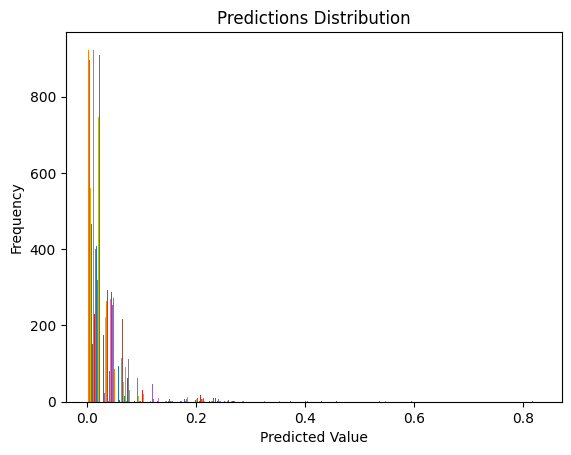

In [ ]:
import matplotlib.pyplot as plt

plt.hist(predict_proba, bins=30)
plt.title("Predictions Distribution")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
submission = pd.DataFrame({'id': id})
columns = [f'Target_{i}' for i in range(125)]
submission[columns] = 0.00001

y_pred_proba = cat_modle.predict_proba(X_test)

for i, class_label in enumerate(cat_modle.classes_):
    submission['Target_' + str(class_label)] = y_pred_proba[:, i]

submission.to_csv('../submissions/submission_part1.csv', index=False)